In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean


In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'pos'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.052170430118614 	 Validation loss: 2.0172665018146323 	 
  1%|          | 574/57400 [02:30<4:19:40,  3.65it/s]
Epoch 2 	 Training loss: 2.002119121028156 	 Validation loss: 2.000664890822718 	 
  2%|▏         | 1148/57400 [05:16<4:20:57,  3.59it/s]
Epoch 3 	 Training loss: 1.9899202198932395 	 Validation loss: 1.997979000463324 	 
  3%|▎         | 1722/57400 [08:03<3:37:11,  4.27it/s]
Epoch 4 	 Training loss: 1.9790634629203052 	 Validation loss: 1.9830192489139105 	 
  4%|▍         | 2296/57400 [10:55<6:20:38,  2.41it/s]
Epoch 5 	 Training loss: 1.9741369261558879 	 Validation loss: 1.9858190993131217 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [14:19<5:13:45,  2.90it/s]
Epoch 6 	 Training loss: 1.9667800758358494 	 Validation loss: 1.9804834430500613 	 
  6%|▌         | 3444/57400 [17:07<4:10:32,  3.59it/s]
Epoch 7 	 Training loss: 1.9658047891244657 	 Validation loss: 1.9775508561376798 	 
  7%|▋         | 4018/57400 [19:53<3:29:47,  4.24it

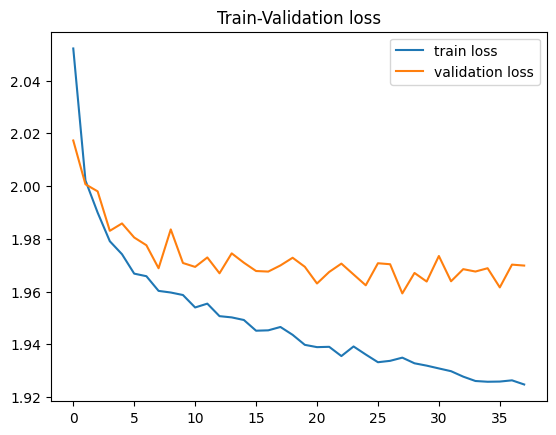

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_pos_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6654040404040404, 'precision': 0.6654040404040404, 'f1': 0.6654040404040404, 'accuracy': 0.6654040404040404}, 'as': {'recall': 0.7222946544980443, 'precision': 0.7222946544980443, 'f1': 0.7222946544980443, 'accuracy': 0.7222946544980443}, 'about': {'recall': 0.8239795918367347, 'precision': 0.8239795918367347, 'f1': 0.8239795918367347, 'accuracy': 0.8239795918367347}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6958637469586375, 'precision': 0.6958637469586375, 'f1': 0.6958637469586375, 'accuracy': 0.6958637469586375}, 'as': {'recall': 0.6994949494949495, 'precision': 0.6994949494949495, 'f1': 0.6994949494949495, 'accuracy': 0.6994949494949495}, 'about': {'recall': 0.84375, 'precision': 0.84375, 'f1': 0.84375, 'accuracy': 0.84375}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6325459317585301, 'precision': 0.6325459317585301, 'f1': 0.6325459317585301, 'accuracy': 0.6325459317585301}, 'as': {'recall': 0.7466307277628033, 'precisio

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.05427559472958 	 Validation loss: 2.01396699072951 	 
  1%|          | 574/57400 [02:18<3:03:49,  5.15it/s]
Epoch 2 	 Training loss: 1.9939742401917222 	 Validation loss: 1.9953024003465296 	 
  2%|▏         | 1148/57400 [04:37<3:46:04,  4.15it/s]
Epoch 3 	 Training loss: 1.9832338586916907 	 Validation loss: 1.9901374113761772 	 
  3%|▎         | 1722/57400 [06:56<3:39:51,  4.22it/s]
Epoch 4 	 Training loss: 1.9769236609495475 	 Validation loss: 1.9807261996350045 	 
  4%|▍         | 2296/57400 [09:14<3:41:53,  4.14it/s]
Epoch 5 	 Training loss: 1.9706370024730935 	 Validation loss: 1.9709195080450026 	 
  5%|▌         | 2870/57400 [11:33<3:32:17,  4.28it/s]
Epoch 6 	 Training loss: 1.9673696883048746 	 Validation loss: 1.978448538456933 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [13:51<3:26:54,  4.35it/s]
Epoch 7 	 Training loss: 1.963876581358162 	 Validation loss: 1.9813929068840157 	 

2 epoch without improvement
  7%|▋         | 4018/57

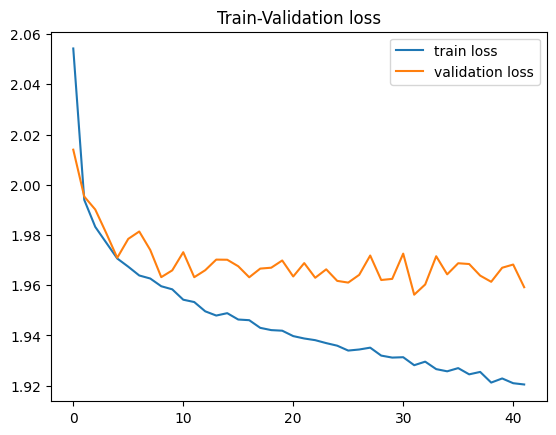

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_pos_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6603535353535354, 'precision': 0.6603535353535354, 'f1': 0.6603535353535354, 'accuracy': 0.6603535353535354}, 'as': {'recall': 0.7327249022164276, 'precision': 0.7327249022164276, 'f1': 0.7327249022164276, 'accuracy': 0.7327249022164276}, 'about': {'recall': 0.8125, 'precision': 0.8125, 'f1': 0.8125, 'accuracy': 0.8125}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6885644768856448, 'precision': 0.6885644768856448, 'f1': 0.6885644768856448, 'accuracy': 0.6885644768856448}, 'as': {'recall': 0.7045454545454546, 'precision': 0.7045454545454546, 'f1': 0.7045454545454546, 'accuracy': 0.7045454545454546}, 'about': {'recall': 0.8203125, 'precision': 0.8203125, 'f1': 0.8203125, 'accuracy': 0.8203125}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6299212598425197, 'precision': 0.6299212598425197, 'f1': 0.6299212598425197, 'accuracy': 0.6299212598425197}, 'as': {'recall': 0.7628032345013477, 'precision': 0.7628032345013477, 'f1': 0.76280323

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0360793257424223 	 Validation loss: 2.0026045593164734 	 
  1%|          | 574/57400 [02:25<3:12:38,  4.92it/s]
Epoch 2 	 Training loss: 1.9879397241080679 	 Validation loss: 1.9819348121093492 	 
  2%|▏         | 1148/57400 [04:50<4:00:29,  3.90it/s]
Epoch 3 	 Training loss: 1.975422027219048 	 Validation loss: 1.979980660697161 	 
  3%|▎         | 1722/57400 [07:16<3:49:30,  4.04it/s]
Epoch 4 	 Training loss: 1.9721251863220428 	 Validation loss: 1.9770785065020544 	 
  4%|▍         | 2296/57400 [09:42<3:44:34,  4.09it/s]
Epoch 5 	 Training loss: 1.9673954346038738 	 Validation loss: 1.9704203241962497 	 
  5%|▌         | 2870/57400 [12:07<3:44:49,  4.04it/s]
Epoch 6 	 Training loss: 1.9656372512674498 	 Validation loss: 1.9745097342184035 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [14:32<3:44:23,  4.01it/s]
Epoch 7 	 Training loss: 1.962392054160713 	 Validation loss: 1.9644539154182046 	 
  7%|▋         | 4018/57400 [16:58<3:53:43,  3.81i

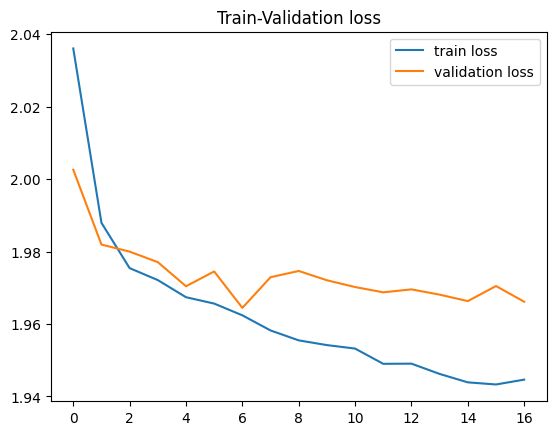

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_pos_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6527777777777778, 'precision': 0.6527777777777778, 'f1': 0.6527777777777778, 'accuracy': 0.6527777777777778}, 'as': {'recall': 0.6923076923076923, 'precision': 0.6923076923076923, 'f1': 0.6923076923076923, 'accuracy': 0.6923076923076923}, 'about': {'recall': 0.8201530612244898, 'precision': 0.8201530612244898, 'f1': 0.8201530612244898, 'accuracy': 0.8201530612244898}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}, 'as': {'recall': 0.6540404040404041, 'precision': 0.6540404040404041, 'f1': 0.6540404040404041, 'accuracy': 0.6540404040404041}, 'about': {'recall': 0.828125, 'precision': 0.828125, 'f1': 0.828125, 'accuracy': 0.828125}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6377952755905512, 'precision': 0.6377952755905512, 'f1': 0.6377952755905512, 'accuracy': 0.6377952755905512}, 'as': {'recall': 0.7331536388140162, 'prec

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8188775510204082, 'precision': 0.8188775510204082, 'f1': 0.8188775510204082, 'accuracy': 0.8188775510204082}
Métricas etiqueta male: {'recall': 0.8307291666666666, 'precision': 0.8307291666666666, 'f1': 0.8307291666666666, 'accuracy': 0.8307291666666666}
Métricas etiqueta female:  {'recall': 0.8075, 'precision': 0.8075, 'f1': 0.8075, 'accuracy': 0.8075}

 to
Resultado global: {'recall': 0.6595117845117845, 'precision': 0.6595117845117845, 'f1': 0.6595117845117845, 'accuracy': 0.6595117845117845}
Métricas etiqueta male: {'recall': 0.683698296836983, 'precision': 0.683698296836983, 'f1': 0.683698296836983, 'accuracy': 0.683698296836983}
Métricas etiqueta female:  {'recall': 0.6334208223972003, 'precision': 0.6334208223972003, 'f1': 0.6334208223972003, 'accuracy': 0.6334208223972003}

 as
Resultado global: {'recall': 0.7157757496740548, 'precision': 0.7157757496740548, 'f1': 0.7157757496740548, 'accuracy': 0.7157757496740548}
Mét